# 🌦️ Weather Classification Project

# 📘 Tổng quan Dự án

## 🎯 Bài toán
Chúng ta sẽ xây dựng mô hình **phân loại loại thời tiết** dựa trên các đặc trưng khí tượng 
như: nhiệt độ, độ ẩm, tốc độ gió, áp suất, mây che phủ, mùa, v.v.

- **Input:** dữ liệu khí tượng (Temperature, Humidity, Wind Speed, Cloud Cover, Season, …)  
- **Output:** nhãn phân loại (Weather Type: Sunny, Rainy, Snowy, Cloudy, …)

## 🚀 Ý nghĩa
- Ứng dụng trong **dự báo thời tiết ngắn hạn**.  
- Hỗ trợ **nông nghiệp, hàng không, giao thông**.  
- Có thể mở rộng để tích hợp vào các hệ thống **IoT giám sát môi trường**.

---

# 📑 Mục lục

- [📘 Tổng quan Dự án](#-Tổng-quan-Dự-án)
- [📑 Mục lục](#-Mục-lục)
- [❄️ Thiết lập Môi trường](#%EF%B8%8F-Thiết-lập-Môi-trường)
- [🌈 Khám phá và Tiền xử lý dữ liệu (EDA)](#-Khám-phá-và-Tiền-xử-lý-dữ-liệu-EDA)
- [🧪 Thí nghiệm](#-Thí-nghiệm)
- [📝 Kết luận](#-Kết-luận)


---


# 1. ⚙️ Thiết lập Môi trường
Trong phần này, chúng ta sẽ nhập tất cả các thư viện cần thiết, định nghĩa các hằng số và tải tập dữ liệu.

1.1. Nhập các thư viện cần thiết

In [1]:
# Xử lý dữ liệu & Đại số tuyến tính
import numpy as np
import pandas as pd

# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

# Học máy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Util
import logging
import joblib
import warnings
import sys
import os
import random

1.2. Cấu hình và các hàm hỗ trợ

In [2]:
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("viridis")


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

1.3. Tải dữ liệu

In [3]:
sys.path.append(os.path.abspath(".."))

from src import evaluate
from src.preprocess import *
from src import train_svm
from src import train_xgboost
from src import utils

# from src.eda import get_missings_percentage
# from src.models import decision_tree
# from src.models import logistic_regression
# from src.models import random_forest
# from src.models import xgboost_model

In [4]:
# Đặt style cho biểu đồ
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Đọc dữ liệu
data = pd.read_csv("../data/raw/weather_classification_data.csv")

# Kiểm tra kích thước dữ liệu
print("Kích thước dữ liệu:", data.shape)

# Hiển thị 5 dòng đầu tiên
data.head()

Kích thước dữ liệu: (13200, 11)


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


## 2. 📊 Khám phá và Tiền xử lý dữ liệu (EDA)

### 2.1. Tổng quan ban đầu về dữ liệu
Ở bước này chúng ta sẽ:
- Xem thông tin chi tiết về dataset (`info`, `describe`).  
- Thống kê số lượng giá trị bị thiếu.  
- Kiểm tra phân bố của các nhãn trong cột `Weather Type` (target).  


In [5]:
# Cấu hình hiển thị đẹp
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Đặt seed để tái lập kết quả
def set_seed(seed=42):
    np.random.seed(seed)

set_seed(42)

In [6]:
display("🔎 Thông tin dữ liệu:")
data.info()

'🔎 Thông tin dữ liệu:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [7]:
# Thống kê mô tả cho các cột số
print("\nThống kê mô tả các biến numerical:")
display(data.describe())


Thống kê mô tả các biến numerical:


,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


In [8]:
# Thống kê mô tả cho các cột phân loại
print("\nThống kê mô tả các biến phân loại:")
display(data.describe(include="object"))


Thống kê mô tả các biến phân loại:


,Cloud Cover,Season,Location,Weather Type
count,13200,13200,13200,13200
unique,4,4,3,4
top,overcast,Winter,inland,Rainy
freq,6090,5610,4816,3300


In [9]:
print(f"Số dòng bị trùng lặp: {data.duplicated().sum()}")

Số dòng bị trùng lặp: 0


In [10]:
# Kiểm tra giá trị thiếu
print("\n❓ Phần trăm giá trị thiếu theo từng cột:")
get_missings_percentage(data, data.columns)



❓ Phần trăm giá trị thiếu theo từng cột:


,%Missing
Temperature,0.0%
Humidity,0.0%
Wind Speed,0.0%
Precipitation (%),0.0%
Cloud Cover,0.0%
Atmospheric Pressure,0.0%
UV Index,0.0%
Season,0.0%
Visibility (km),0.0%
Location,0.0%


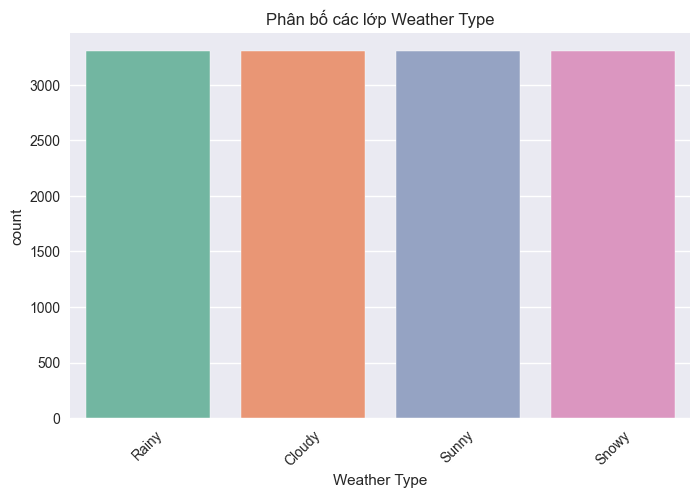

In [11]:
# Phân bố target (Weather Type)
plt.figure(figsize=(8,5))
sns.countplot(x="Weather Type", data=data, order=data["Weather Type"].value_counts().index, palette="Set2")
plt.title("Phân bố các lớp Weather Type")
plt.xticks(rotation=45)
plt.show()

📝 **Nhận xét:**  
> Bộ dữ liệu có **13200 mẫu**, với **11 đặc trưng** và **1 biến mục tiêu**  
> - 7 đặc trưng dạng số  
> - 4 đặc trưng dạng object (categorical)  
> - Không thuộc tính nào có missing value  
> - Không có mẫu trùng lặp
    

### 🌿 2.2. Phân tích đơn biến
Ở đây ta sẽ:
- Vẽ **histogram** cho các cột số để xem phân phối.  
- Vẽ **boxplot** để phát hiện ngoại lai (outliers).  


2.2.1. Phân phối dữ liệu

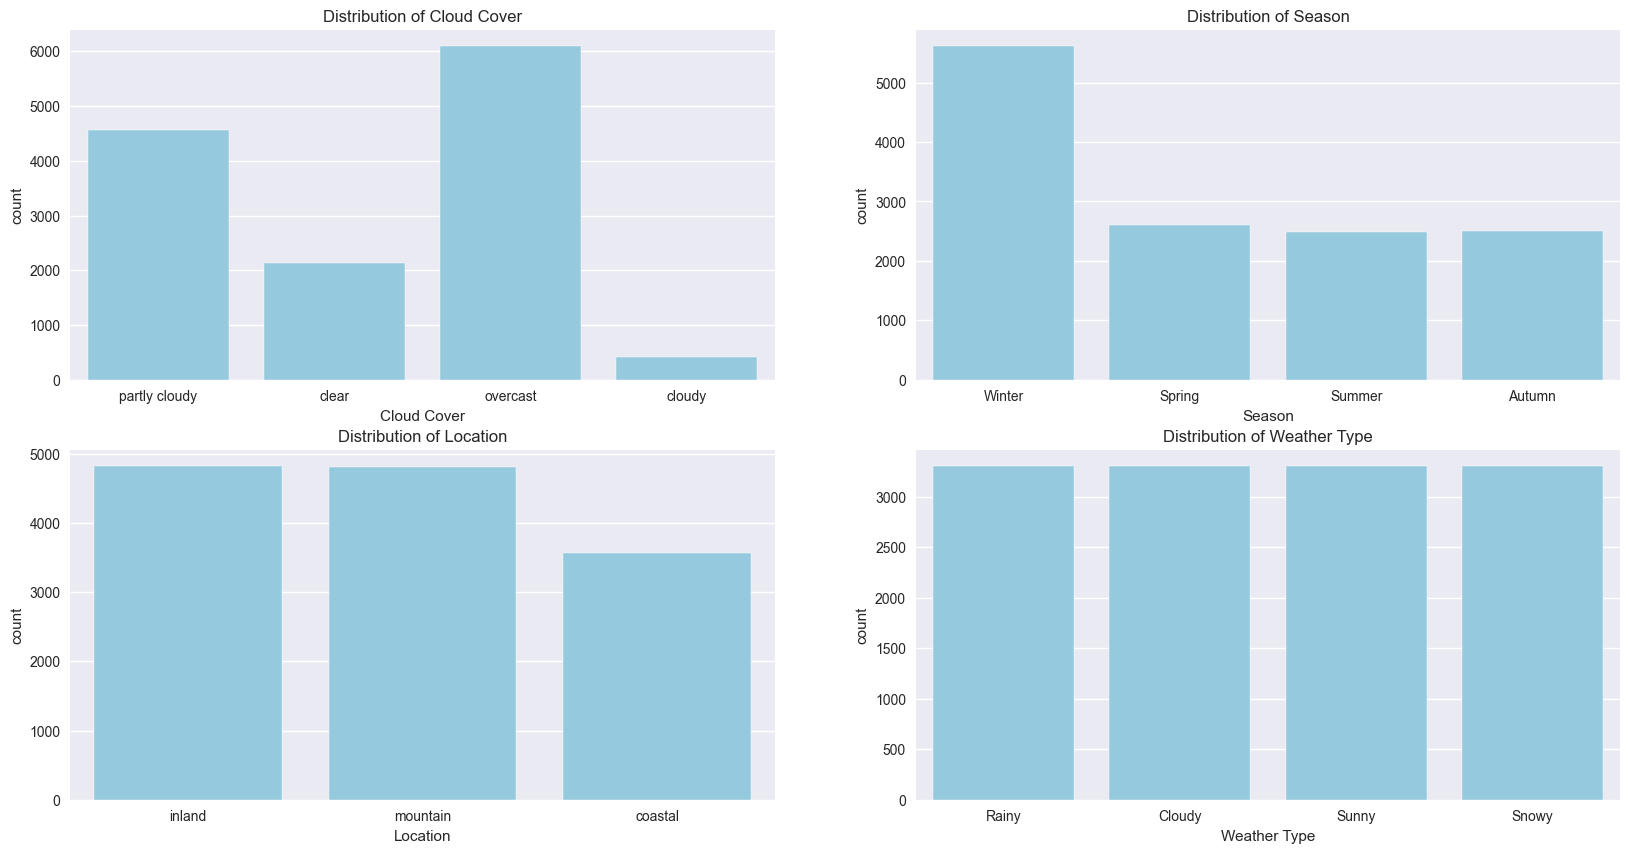

In [12]:
# Biểu đồ phân phối các biến phân loại
categorical_interests = ["Cloud Cover","Season","Location","Weather Type"]
fig, axis = plt.subplots(2, 2, figsize=(20, 10))
for i, col in enumerate(categorical_interests):
    color = "green" if col == "Transported" else "skyblue"
    ax = axis[i // 2, i % 2]
    sns.countplot(data=data, x=col, ax=ax, color=color)
    ax.set_title(f"Distribution of {col}")
# fig.delaxes(axis[1, 2])

📝 **Nhận xét**

**Cloud Cover**  
- Overcast: chiếm đa số (khoảng 6000)  
- Partly cloudy: đứng thứ hai (khoảng 4500)  
- Clear: ít hơn (khoảng 2000)  
- Cloudy: rất ít (dưới 500)  
→ Tập dữ liệu nghiêng mạnh về Overcast và Partly cloudy, trong khi Cloudy xuất hiện rất hiếm.  

**Season**  
- Winter: chiếm đa số (hơn 5000)  
- Spring, Summer, Autumn: tương đối đồng đều, khoảng 2500–2700 mỗi mùa  
→ Hành khách tập trung chủ yếu vào mùa đông, các mùa khác ít hơn một nửa.  

**Location**  
- Inland: khoảng 4700  
- Mountain: gần tương đương (~4700)  
- Coastal: ít hơn (~3600)  
→ Phân phối tương đối cân bằng, nhưng Coastal ít hơn so với hai loại còn lại.  

**Weather Type**  
- Rainy, Cloudy, Sunny, Snowy: gần như bằng nhau (~3200 mỗi loại)  
→ Biến mục tiêu có phân phối cân bằng, thuận lợi cho mô hình học.  


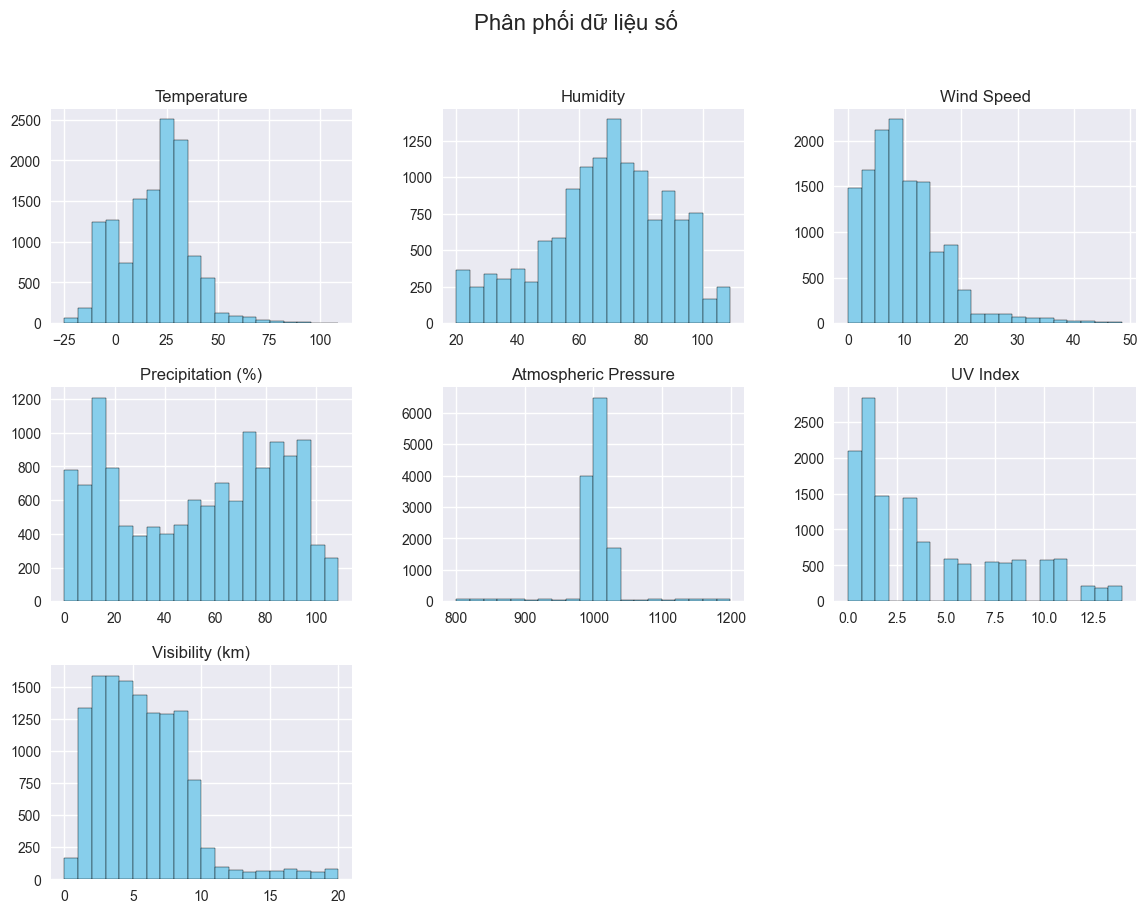

In [13]:
# Histogram cho các đặc trưng số
num_cols = data.select_dtypes(include=[np.number]).columns

data[num_cols].hist(bins=20, figsize=(14,10), color="skyblue", edgecolor="black")
plt.suptitle("Phân phối dữ liệu số", fontsize=16)
plt.show()

📝 **Nhận xét**

**Temperature**  
- Tập trung nhiều trong khoảng 20–40°C  
- Có một số giá trị âm bất thường  
→ Dữ liệu có phân phối lệch phải, cần kiểm tra và xử lý ngoại lệ  

**Humidity**  
- Phân phối tương đối đồng đều  
- Tập trung nhiều ở khoảng 50–90%  
→ Dữ liệu đa dạng, không có mất cân bằng nghiêm trọng  

**Wind Speed**  
- Phần lớn giá trị < 15 km/h  
- Ít mẫu có tốc độ gió cao (> 20 km/h)  
→ Phân phối lệch phải, chủ yếu tốc độ gió thấp  

**Precipitation (%)**  
- Có nhiều đỉnh (multimodal)  
- Xuất hiện giá trị ở hầu hết khoảng 0–100%  
→ Phân phối khá phức tạp, thể hiện sự thay đổi đa dạng của lượng mưa  

**Atmospheric Pressure**  
- Tập trung rất mạnh quanh 1000 hPa  
- Có một số giá trị ngoài khoảng 900–1100 hPa  
→ Dữ liệu gần phân phối chuẩn, có khả năng xuất hiện ngoại lệ  

**UV Index**  
- Chủ yếu tập trung < 3  
- Một số ít giá trị cao ≥ 10  
→ Phân phối lệch phải, có outlier  

**Visibility (km)**  
- Tập trung nhiều ở 0–10 km, đặc biệt dưới 5 km  
- Một số giá trị > 15 km xuất hiện ít  
→ Phân phối lệch phải, chủ yếu tầm nhìn thấp  


2.2.2. Ngoại lai

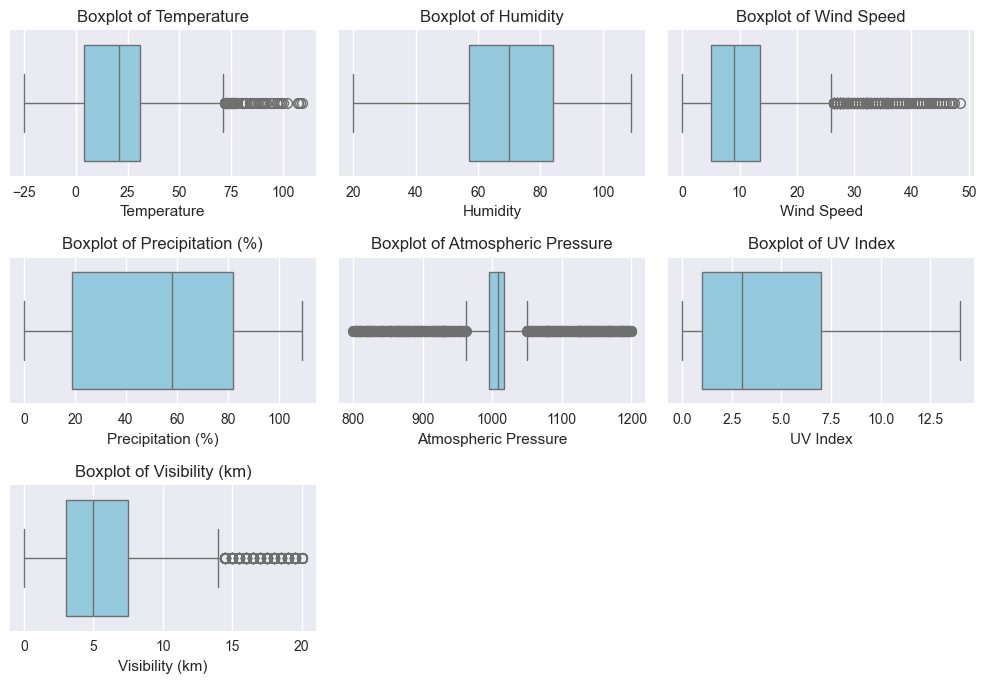

In [14]:
# Boxplot để kiểm tra ngoại lai
# plt.figure(figsize=(14,8))
# sns.boxplot(data=data[num_cols], palette="coolwarm")
# plt.title("📌 Boxplot phát hiện ngoại lai")
# plt.xticks(rotation=45)
# plt.show()

fig, axis = plt.subplots(3, 3, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax = axis[i // 3, i % 3]
    sns.boxplot(x=data[col], ax=ax, color="skyblue")
    ax.set_title(f"Boxplot of {col}")
for j in range(1,3):
    fig.delaxes(axis[2,j])
plt.tight_layout()

📝 **Nhận xét**

- **Temperature**
  - Dữ liệu tập trung chủ yếu từ **0–40°C**.  
  - Có nhiều outlier ở phía trên (**> 50°C**).  
  - Phân phối lệch phải, cần cân nhắc xử lý ngoại lệ.  

- **Humidity**
  - Phân phối khá đồng đều trong khoảng **30–100%**.  
  - Gần như không có outlier.  
  - Biến ổn định, ít bất thường.  

- **Wind Speed**
  - Tập trung nhiều ở mức **< 20 km/h**.  
  - Có nhiều outlier ở phía trên (**20–50 km/h**).  
  - Phân phối lệch phải.  

- **Precipitation (%)**
  - Giá trị trải rộng toàn bộ khoảng **0–100%**.  
  - Một vài outlier nhưng không đáng kể.  
  - Thể hiện tính biến động lớn, hợp lý với đặc trưng lượng mưa.  

- **Atmospheric Pressure**
  - Tập trung mạnh quanh **1000 hPa**.  
  - Rất nhiều outlier ở cả hai phía (**< 950 hPa và > 1050 hPa**).  
  - Cần kiểm tra kỹ dữ liệu ngoại lệ để tránh gây nhiễu.  

- **UV Index**
  - Phần lớn nằm trong khoảng **0–10**.  
  - Có một số outlier ở mức cao hơn.  
  - Phân phối lệch phải nhẹ.  

- **Visibility (km)**
  - Tập trung nhiều ở mức **< 10 km**.  
  - Xuất hiện nhiều outlier ở phía trên (**> 15 km**).  
  - Biến có xu hướng lệch phải.  

### 🔗 2.3. Phân tích đa biến
Ở đây chúng ta sẽ:
- Tính **ma trận tương quan** giữa các biến số.  
- Vẽ heatmap để quan sát mối liên hệ. 

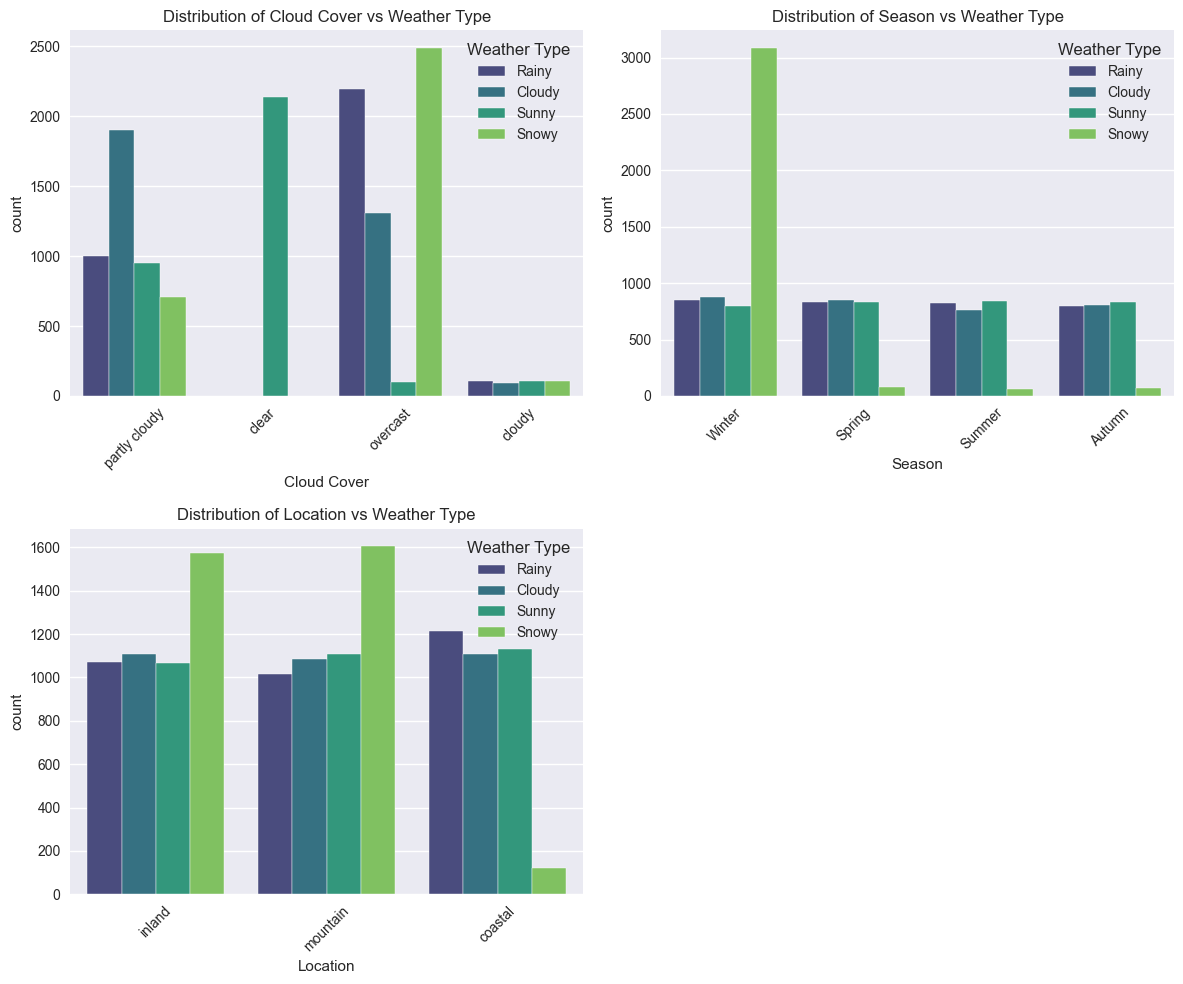

In [15]:
# Tạo khung figure 2x2
fig, axis = plt.subplots(2, 2, figsize=(12, 10))

# Các biến phân loại để so với Weather Type
categorical_multi = ['Cloud Cover', 'Season', 'Location']  

for i, col in enumerate(categorical_multi):
    ax = axis[i // 2, i % 2]
    sns.countplot(data=data, x=col, ax=ax, hue="Weather Type", palette="viridis")
    ax.set_title(f"Distribution of {col} vs Weather Type")
    ax.tick_params(axis='x', rotation=45)
fig.delaxes(axis[1,1])
plt.tight_layout()
plt.show()

📝 **Nhận xét từ các biểu đồ phân phối Weather Type**

1. **Cloud Cover vs Weather Type**
   - **Partly cloudy**: Chủ yếu là **Cloudy** và **Rainy**, ít Sunny và Snowy.  
   - **Clear**: Tập trung nhiều ở **Sunny**, tiếp theo là **Rainy**.  
   - **Overcast**: Chủ yếu là **Rainy** và **Cloudy**, gần như không có Sunny, Snowy ít.  
   - **Cloudy**: Rất ít quan sát, phân bổ khá đồng đều giữa các Weather Type.  
   👉 Điều này cho thấy: Cloud Cover có ảnh hưởng rõ rệt đến loại thời tiết, ví dụ trời quang thì đa phần là **Sunny**, còn khi overcast thì khả năng cao là **Rainy**.  

2. **Season vs Weather Type**
   - **Winter**: Chủ yếu là **Snowy**, số lượng vượt trội so với các loại khác.  
   - **Spring**: Phân phối khá cân bằng giữa Rainy, Cloudy, Sunny.  
   - **Summer**: Tương tự Spring, các loại thời tiết khá cân bằng.  
   - **Autumn**: Cũng tương đối cân bằng, không có loại nào áp đảo.  
   👉 Điều này phản ánh tính mùa vụ rõ rệt: **Winter gắn với Snowy**, còn các mùa còn lại thì thời tiết đa dạng hơn, không có sự chiếm ưu thế tuyệt đối.  

3. **Location vs Weather Type**
   - **Inland**: Phân bố khá đồng đều, không có loại nào chiếm ưu thế.  
   - **Mountain**: Nổi bật là **Snowy**, số lượng lớn nhất.  
   - **Coastal**: Chủ yếu là **Rainy** và **Cloudy**, Sunny cũng nhiều, Snowy rất ít.  
   👉 Điều này cho thấy yếu tố địa lý ảnh hưởng mạnh đến thời tiết: **Mountain thường Snowy**, trong khi **Coastal dễ Rainy/Cloudy**.  

---
<!-- 
### Tổng kết
- **Cloud Cover** và **Season** là hai yếu tố có sự phân hóa rõ rệt nhất theo Weather Type.  
- **Winter → Snowy**, **Clear → Sunny**, **Overcast → Rainy** là những quy luật nổi bật.  
- **Location** cũng ảnh hưởng nhưng không mạnh bằng Season và Cloud Cover, ngoại trừ **Mountain → Snowy**.   -->

<Axes: xlabel='Weather Type', ylabel='Humidity'>

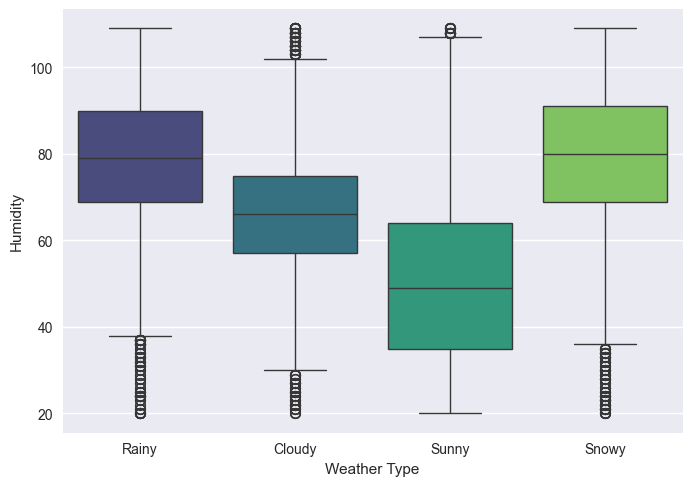

In [16]:
sns.boxplot(data = data, x=data["Weather Type"], y=data["Humidity"], palette="viridis")

📝 **Nhận xét**

**Rainy**: Độ ẩm cao, tập trung quanh 75–85%. Median gần 80%. Phần lớn dữ liệu nằm ở mức cao, đúng với đặc trưng thời tiết mưa.  
- **Cloudy**: Độ ẩm trung bình, median khoảng 65%. Độ phân tán thấp hơn Rainy và Snowy.  
- **Sunny**: Độ ẩm thấp nhất trong các loại thời tiết, median khoảng 50%. Độ biến thiên rộng, có nhiều giá trị thấp (dưới 30%) và một số outlier cao.  
- **Snowy**: Độ ẩm cao, median gần 80%. Phân phối rộng, trải từ thấp (~40%) đến cao (>100%).   
👉 Như vậy, Weather Type là biến có khả năng phân tách mạnh theo Humidity.

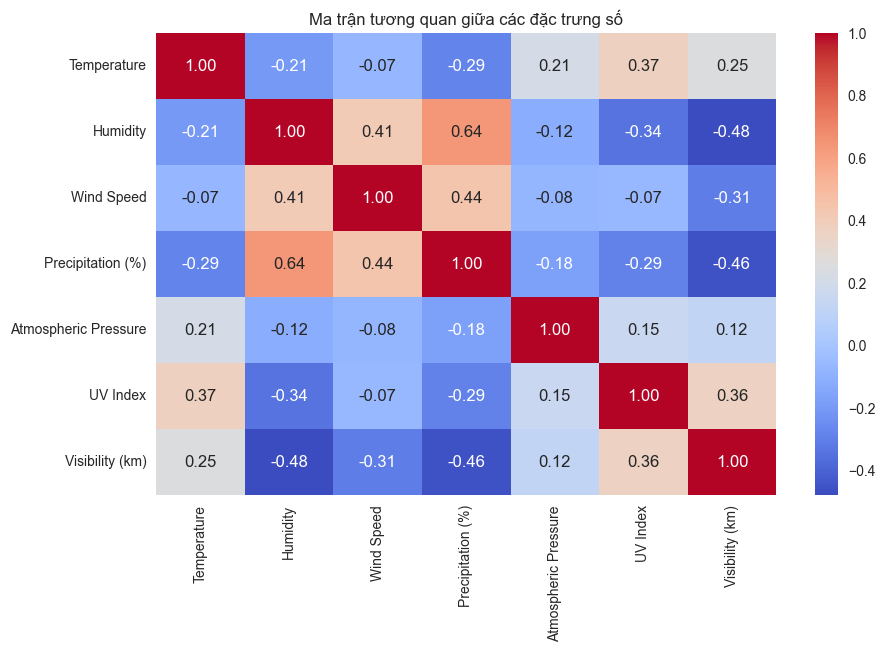

In [17]:
# Ma trận tương quan (chỉ cho cột số)
plt.figure(figsize=(10,6))
corr = data[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các đặc trưng số")
plt.show()


📝 **Nhận xét**
- Hầu hết các đặc trưng có mức tương quan yếu đến trung bình.  
- **Độ ẩm (Humidity)** có tương quan dương khá mạnh với **Lượng mưa** (Precipitation, 0.64) và với **Tốc độ gió** (Wind Speed, 0.41).  
- **Tốc độ gió (Wind Speed)** cũng tương quan dương với Lượng mưa (Precipitation, 0.44).  
- **Độ ẩm (Humidity)** và **Tầm nhìn (Visibility)** có tương quan âm khá rõ (-0.48), tức là ẩm cao thì tầm nhìn giảm.  
- **Nhiệt độ (Temperature)** tương quan dương trung bình với **Chỉ số UV** (UV Index, 0.37).  
- Các cặp biến còn lại có tương quan yếu, gần như độc lập.  
👉 Nhìn chung, không có hiện tượng đa cộng tuyến mạnh (không có cặp nào > 0.8), nên có thể dùng đồng thời trong mô hình.

### 🔗 2.4. Tiền xử lý dữ liệu
Sau khi đã khám phá dữ liệu, bước tiếp theo và quan trọng nhất là chuẩn bị và biến đổi dữ liệu thô thành một định dạng "sạch" và có cấu trúc mà các mô hình học máy có thể hiểu được. Quá trình này bao gồm ba giai đoạn chính:
1.  **Xây dựng Pipeline tiền xử lý:** Thiết lập các quy trình tự động để chuẩn hóa dữ liệu số và mã hóa dữ liệu phân loại.
2.  **Phân chia Dữ liệu:** Chia dữ liệu thành các tập huấn luyện/kiểm tra để chuẩn bị cho việc huấn luyện mô hình.

#### 2.4.1. Xây dựng Pipeline tiền xử lý
Chúng ta sẽ xây dựng một `Pipeline` bằng `ColumnTransformer` của Scikit-learn. Cách tiếp cận này rất hiệu quả vì nó cho phép:
- Áp dụng các phép biến đổi khác nhau cho các loại cột khác nhau (số và phân loại).
- Tự động hóa toàn bộ quy trình, tránh rò rỉ dữ liệu (data leakage) từ tập test sang tập train.
- Dễ dàng tích hợp vào quy trình huấn luyện và tinh chỉnh mô hình.

Cụ thể:
- **Dữ liệu số (`numerical_features`):** Sẽ được chuẩn hóa bằng `StandardScaler` để đưa về cùng một thang đo, giúp các thuật toán hội tụ nhanh hơn và giảm ảnh hưởng của ngoại lai.
- **Dữ liệu phân loại (`categorical_features`):** Sẽ được mã hóa bằng `OneHotEncoder` để chuyển các giá trị text thành dạng số mà mô hình có thể hiểu được.

In [18]:
# Tách biến độc lập (features) và biến phụ thuộc (target)
X = data.drop("Weather Type", axis=1)
y = data["Weather Type"]

# Xác định các cột số và cột phân loại
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=object).columns

print(f"Numerical features: {list(numerical_features)}")
print(f"Categorical features: {list(categorical_features)}")

Numerical features: ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)']
Categorical features: ['Cloud Cover', 'Season', 'Location']


#### 2.4.2. Xây dựng Pipeline tiền xử lý và Phân chia dữ liệu
Chúng ta sẽ thực hiện các bước sau:
1.  **Tách biến độc lập (X) và biến phụ thuộc (y).**
2.  **Mã hóa nhãn (Label Encoding):** Các mô hình thủ công thường làm việc với nhãn dạng số (0, 1, 2, 3) thay vì dạng chữ ('Sunny', 'Rainy'). Chúng ta sẽ dùng `LabelEncoder` để chuyển đổi.
3.  **Chuẩn hóa và Mã hóa X:** Áp dụng `StandardScaler` cho biến số và `OneHotEncoder` cho biến phân loại trên tập train, sau đó biến đổi tập test.

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# 1. Tách X và y
X = data.drop("Weather Type", axis=1)
y = data["Weather Type"]

# 2. Mã hóa nhãn y thành số (0, 1, 2, 3)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Các lớp và mã số tương ứng:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# 3. Xác định cột số và cột phân loại để tiền xử lý X
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=object).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

Các lớp và mã số tương ứng: {'Cloudy': 0, 'Rainy': 1, 'Snowy': 2, 'Sunny': 3}


In [20]:
# Xây dựng pipeline cho tiền xử lý
# 1. Pipeline cho dữ liệu số: Chuẩn hóa
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 2. Pipeline cho dữ liệu phân loại: Mã hóa One-Hot
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Kết hợp hai pipeline bằng ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Giữ lại các cột không được xử lý (nếu có)
)   

#### 2.4.3. Phân chia Dữ liệu
Dữ liệu sẽ được chia thành hai tập:
- **Tập huấn luyện (Training set):** 80% dữ liệu, dùng để huấn luyện mô hình.
- **Tập kiểm tra (Test set):** 20% dữ liệu, dùng để đánh giá hiệu suất cuối cùng của mô hình trên dữ liệu mới.

Chúng ta sử dụng `stratify=y` để đảm bảo tỷ lệ phân bố của các lớp `Weather Type` trong tập train và test là như nhau, điều này rất quan trọng đối với bài toán phân loại.

In [21]:
# Phân chia dữ liệu thành tập train và test (tỷ lệ 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y  # Giữ nguyên tỉ lệ phân bố của target
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print(f"Kích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")
print(f"Kích thước nhãn huấn luyện (y_train): {y_train.shape}")
print(f"Kích thước nhãn kiểm tra (y_test): {y_test.shape}")

Kích thước tập huấn luyện (X_train): (10560, 10)
Kích thước tập kiểm tra (X_test): (2640, 10)
Kích thước nhãn huấn luyện (y_train): (10560,)
Kích thước nhãn kiểm tra (y_test): (2640,)


In [22]:
os.makedirs("../artifacts", exist_ok=True)

joblib.dump(X_train_proc, "../artifacts/X_train_proc.pkl")
joblib.dump(X_test_proc, "../artifacts/X_test_proc.pkl")
joblib.dump(y_train, "../artifacts/y_train.pkl")
joblib.dump(y_test, "../artifacts/y_test.pkl")
joblib.dump(preprocessor, "../artifacts/preprocessor.pkl")

print("✅ Đã lưu xong dữ liệu train/test và preprocessor!")

✅ Đã lưu xong dữ liệu train/test và preprocessor!


### 2.5. Insight và Tổng kết EDA
> 📌 **Kết quả sau tiền xử lý:**  
>
> - **Dữ liệu đã sẵn sàng:** Chúng ta đã hoàn thành việc khám phá, làm sạch và chuẩn bị dữ liệu.
> - **Pipeline tự động:** `preprocessor` được xây dựng sẽ tự động hóa toàn bộ quá trình chuẩn hóa và mã hóa, đảm bảo tính nhất quán và tránh các lỗi thủ công.
> - **Tập train/test:** Dữ liệu đã được phân chia hợp lý, sẵn sàng cho giai đoạn tiếp theo là xây dựng và huấn luyện mô hình.

# 3. 🧪 Thí nghiệm: Xây dựng và Huấn luyện mô hình thủ công
### 3.1. Xây dựng các lớp mô hình (From Scratch)
Dưới đây là các lớp mô hình được xây dựng thủ công, đã được điều chỉnh để phù hợp với bài toán:
- **`OneVsRestClassifier`**: Lớp bao (wrapper) để áp dụng chiến lược One-vs-Rest cho các mô hình nhị phân.
- **`LogisticRegressionScratch`**: Mô hình hồi quy logistic nhị phân (sẽ được dùng bên trong OvR).
- **`DecisionTreeScratch`**: Mô hình cây quyết định đa lớp.
- **`RandomForestScratch`**: Mô hình rừng ngẫu nhiên đa lớp.

### 3.2. Huấn luyện và Đánh giá
Chúng ta sẽ tạo một pipeline hoàn chỉnh cho từng mô hình, bao gồm cả bước tiền xử lý (`preprocessor`) và thuật toán (`classifier`). Sau đó, chúng ta sẽ huấn luyện từng pipeline trên tập `X_train` và đánh giá hiệu suất trên tập `X_test` bằng các độ đo như Accuracy, Precision, Recall và F1-score.